In [1]:
using Revise
using Random
using Plots  # Optional, for plotting

In [2]:
using PauliPropagation

## Example of using `symmetrypropagate` to propagate a Pauli operator through a circuit

This subsection is included in `test_symmetrymerge.jl`

In [3]:
Random.seed!(42) # for 
nq = 3  # number of qubits
nl = 2  # number of layers
W = Inf;                   # maximal operator weight.
min_abs_coeff = 0;          # neglect small coefficients. Only for numerical and hybrid PP.
thetax, thetaz, thetay = randn(nl), randn(nl), randn(nl)
thetas = theta_periodic_brickwork(nq, nl, thetax, thetaz, thetay);
# Observable to compute the expectation value of:
symbs = [:I for _ in 1:nq]
symbs[round(Integer, nq/2)] = :Z   # as symbol. Also works but is slower.
obsint = symboltoint(symbs);  # for performance we work with bitoperations

In [4]:
# Build single layer of translational invariant brickwork circuit
topo = bricklayertopology(nq, periodic=true)  # periodic boundary conditions
circ_layer = hardwareefficientcircuit(nq, 1; topology=topo)
fastcirc_layer = tofastgates(circ_layer)
thetas_layers = reshape(thetas, :, nl);
symbfs = symmetrypropagate(fastcirc_layer, obsint, thetas_layers, nq, nl, W, min_abs_coeff)
# Compare with numerical propagation
full_circuit = hardwareefficientcircuit(nq, nl; topology=topo)
fastfull_circuit = tofastgates(full_circuit)
numbfs  = mergingbfs(fastfull_circuit, obsint, thetas, max_weight=W, min_abs_coeff=min_abs_coeff);

In [5]:
# Check the expectation value from symmetry propagation and numerical propagation are the same
evsym = evalagainstzero(symbfs) # expectation
evnum = evalagainstzero(numbfs) # expectation
@assert isapprox(evnum, evsym; atol=1e-8) "Numerical value $evnum is not equal to symmetry value $evsym for nq = $nq"
evsym - evnum


1.1102230246251565e-16

## Performance comparison

In [28]:
function compare_numerical_symmetry(qubits, layers)
  timed_numerical = Dict()
  timed_symmetry = Dict()
  W = Inf;                   # maximal operator weight.
  min_abs_coeff = 0;          # neglect small coefficients. Only for numerical and hybrid PP.
  for nq in qubits
      # Observable to compute the expectation value of:
      symbs = [:I for _ in 1:nq]
      symbs[round(Integer, nq/2)] = :Z   # as symbol. Also works but is slower.
      obsint = symboltoint(symbs)  # for performance we work with bitoperations
      # println("observable string: ", join(symbs))
      for nl in layers
          #YT: currently if topology and nq are not consistent, the code will throw an error.
          # Consider adding a check to make sure topology and nq are compatible. 
          topo = bricklayertopology(nq, periodic=true)  # periodic boundary conditions
          # Build brickwork circuit
          circ = hardwareefficientcircuit(nq, nl; topology=topo)
          fastcirc = tofastgates(circ)
          thetas = theta_periodic_brickwork(nq, nl, randn(nl), randn(nl), randn(nl));
          t_numerical = @timed mergingbfs(fastcirc, obsint, thetas; max_weight=W, min_abs_coeff=min_abs_coeff);
          ev_numerical = evalagainstzero(t_numerical.value)
          # push!(times_numerical, t_numerical.time)
          timed_numerical[(nq, nl)] = t_numerical

          # Build single layer of translational invariant brickwork circuit
          circ_layer = hardwareefficientcircuit(nq, 1; topology=topo)
          fastcirc_layer = tofastgates(circ_layer)
          thetas_layers = reshape(thetas, :, nl);
          t_symmetry = @timed symmetrypropagate(fastcirc_layer, obsint, thetas_layers, nq, nl, W, min_abs_coeff)
          ev_symmetry = evalagainstzero(t_symmetry.value)
          # push!(times_symmetry, t_symmetry.time)
          timed_symmetry[(nq, nl)] = t_symmetry

          # Check numerical and symmetry expectation are the same
          @assert isapprox(ev_numerical, ev_symmetry; atol=1e-5) "Numerical value $ev_numerical is not equal to symmetry value $ev_symmetry for nq = $nq"
      end
  end
return timed_numerical, timed_symmetry
end


compare_numerical_symmetry (generic function with 1 method)

In [35]:
Random.seed!(42) # for reproducibility
layers = [1, 6, 9]
qubits = 5:2:9
timed_numerical, timed_symmetry = compare_numerical_symmetry(qubits, layers)

(Dict{Any, Any}((9, 6) => (value = Dict{UInt32, Float64}(0x0002d67f => 3.1721407265309052e-6, 0x00035fc0 => -2.0843008172098523e-5, 0x00016975 => -4.8955209410465525e-6, 0x00012c72 => -1.982815648126789e-6, 0x000090ec => -2.4890720611784546e-5, 0x0002a64b => 3.951751982764905e-7, 0x0002d2ea => 4.401431896187172e-6, 0x0002e911 => -1.4769565532614321e-6, 0x00039844 => -4.729519290791372e-7, 0x0000f5f1 => 4.113041145520634e-6…), time = 2.387590125, bytes = 32599936, gctime = 0.0, gcstats = Base.GC_Diff(32599936, 41, 0, 505, 29, 0, 0, 0, 0)), (9, 9) => (value = Dict{UInt32, Float64}(0x0002d67f => 0.0008340173942251903, 0x00035fc0 => 0.0014843435289043105, 0x00016975 => -0.00013439212580746367, 0x00012c72 => 0.0003594378976785881, 0x000090ec => 0.004749895964573394, 0x0002a64b => 0.0010177521753545304, 0x0002d2ea => 0.00014588188777904694, 0x0002e911 => -9.014709113572771e-6, 0x00039844 => 0.0004088733023122113, 0x0000f5f1 => 0.004271262449291201…), time = 6.312549107, bytes = 32607792, gct

In [36]:
# Extract time only as a dictionary
times_numerical = Dict(k => v.time for (k, v) in timed_numerical)
times_symmetry = Dict(k => v.time for (k, v) in timed_symmetry)
# Extract memory only as a dictionary
memory_numerical = Dict(k => v.bytes for (k, v) in timed_numerical)
memory_symmetry = Dict(k => v.bytes for (k, v) in timed_symmetry);


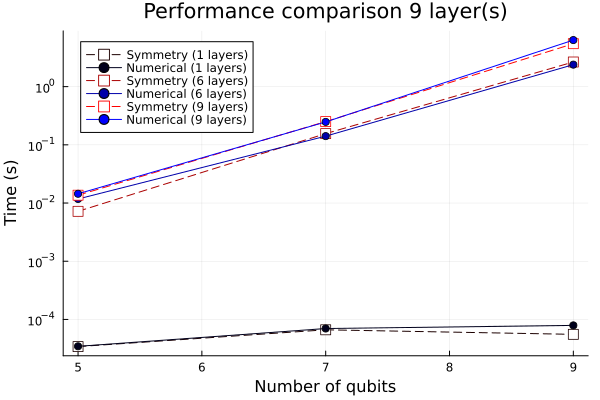

Number of qubits: 5:2:9
Numerical times: Dict((9, 6) => 2.387590125, (9, 9) => 6.312549107, (5, 1) => 3.453e-5, (7, 1) => 6.9796e-5, (5, 6) => 0.011753799, (5, 9) => 0.014434102, (7, 6) => 0.141123811, (7, 9) => 0.247836298, (9, 1) => 7.8993e-5)
Symmetry times: Dict((9, 6) => 2.652203897, (9, 9) => 5.470692988, (5, 1) => 3.4134e-5, (7, 1) => 6.6324e-5, (5, 6) => 0.007197543, (5, 9) => 0.01363652, (7, 6) => 0.155900782, (7, 9) => 0.25080205, (9, 1) => 5.5438e-5)


In [37]:

# Print the results
println("Number of qubits: ", qubits)
println("Numerical times: ", times_numerical)
println("Symmetry times: ", times_symmetry)

# Create an empty plot 
Plot = plot()

# Plot the performance as a function of parameter `n`
for d in layers
    times_numerical_n = [times_numerical[(n, d)] for n in qubits]
    times_symmetry_n = [times_symmetry[(n, d)] for n in qubits]
    # Display d in different gradient of color
    colors_numerical = [RGB(0, 0, d/maximum(layers)) for _ in 1:length(qubits)]
    colors_symmetry = [RGB(d/maximum(layers), 0, 0) for _ in 1:length(qubits)]
    

    plot!(
        Plot, qubits, times_symmetry_n, 
        label="Symmetry ($d layers)" ,marker=:square, color=colors_symmetry,
        yscale=:log10, markersize=5,
        markercolor=RGBA(1, 1, 1, 0), markerstrokecolor=colors_symmetry, linestyle=:dash
        # color=colors_symmetry, markercolor=:transparent,
    )
    plot!(Plot, qubits, times_numerical_n, 
        label="Numerical ($d layers)" ,marker=:circle, color=colors_numerical,
        yscale=:log10, 
        xlabel="Number of qubits", ylabel="Time (s)", title="Performance comparison $d layer(s)"
    )
    plot!(Plot, legend=:topleft)
end
display(Plot)

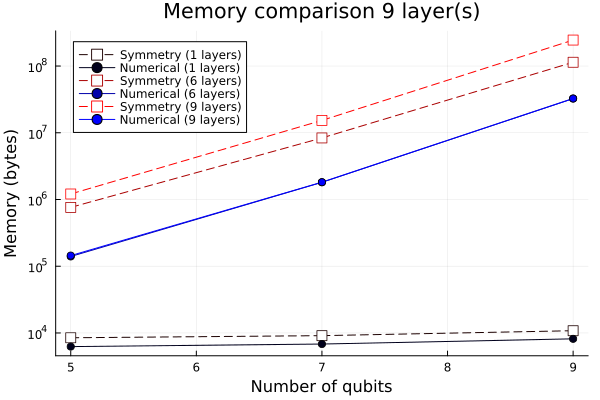

In [38]:
# Figure for memory usage
Plot = plot()

# Plot the performance as a function of parameter `n`
for d in layers
    memory_numerical_n = [memory_numerical[(n, d)] for n in qubits]
    memory_symmetry_n = [memory_symmetry[(n, d)] for n in qubits]
    # Display d in different gradient of color
    colors_numerical = [RGB(0, 0, d/maximum(layers)) for _ in 1:length(qubits)]
    colors_symmetry = [RGB(d/maximum(layers), 0, 0) for _ in 1:length(qubits)]
    

    plot!(
        Plot, qubits, memory_symmetry_n, 
        label="Symmetry ($d layers)" ,marker=:square, color=colors_symmetry,
        yscale=:log10, markersize=5,
        markercolor=RGBA(1, 1, 1, 0), markerstrokecolor=colors_symmetry, linestyle=:dash
        # color=colors_symmetry, markercolor=:transparent,
    )
    plot!(Plot, qubits, memory_numerical_n, 
        label="Numerical ($d layers)" ,marker=:circle, color=colors_numerical,
        yscale=:log10, 
        xlabel="Number of qubits", ylabel="Memory (bytes)", title="Memory comparison $d layer(s)"
    )
    plot!(Plot, legend=:topleft)
end
display(Plot)